In [1]:
import pandas as pd
import numpy as np

df_movies = pd.read_csv('./ml-20m/movies.csv')
df_ratings = pd.read_csv('./ml-20m/ratings.csv')

movieId_to_name = pd.Series(df_movies.title.values, index=df_movies.movieId.values).to_dict()
name_to_movieId = pd.Series(df_movies.movieId.values, index=df_movies.title).to_dict()

#randomly display 5 records in the dataframe
for df in list((df_movies, df_ratings)):
    rand_idx = np.random.choice(len(df), 5, replace=False)
    display(df.iloc[rand_idx,:])
    print('Displaying 5 of the total ' + str(len(df)) + ' data points')

,movieId,title,genres
5815,5914,"Vernon, Florida (1981)",Documentary
2167,2252,Hero (1992),Comedy|Drama
23594,112316,Jersey Boys (2014),Drama|Musical
21556,104540,"Immortals, The (1995)",Action|Crime|Drama
10087,33312,"Cocoanuts, The (1929)",Comedy|Musical


Displaying 5 of the total 27278 data points


,userId,movieId,rating,timestamp
8967293,61990,1203,4.0,1344131451
3529111,24073,2041,2.0,942966360
7621498,52512,59369,4.0,1363220506
11571687,79902,2761,4.0,1101231527
14098955,97384,2132,5.0,1225339185


Displaying 5 of the total 20000263 data points


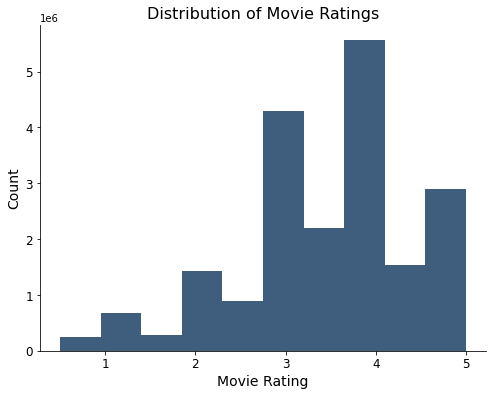

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.set_title('Distribution of Movie Ratings', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Movie Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.hist(df_ratings['rating'], color='#3F5D7D')
plt.show()

In [17]:
from sklearn.model_selection import train_test_split

df_ratings_train, df_rating_test = train_test_split(df_ratings, stratify=df_ratings['userId'], random_state=15688, test_size=0.30)

In [18]:
print('Number of training data:' +str(len(df_ratings_train)))
print('Number of test data:'+str(len(df_rating_test)))

Number of training data:14000184
Number of test data:6000079


In [9]:
def rating_splitter(df):
    df['liked'] = np.where(df['rating']>=4, 1, 0)
    df['movieId'] = df['movieId'].astype(str)
    gp_user_like = df.groupby(['liked', 'userId'])
    return ([gp_user_like.get_group(gp)['movieId'].tolist() for gp in gp_user_like.groups])

In [10]:
pd.options.mode.chained_assignment = None
splitted_movies = rating_splitter(df_ratings_train)

In [11]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
assert gensim.models.word2vec.FAST_VERSION > -1

In [12]:
import random
for movie_list in splitted_movies:
    random.shuffle(movie_list)

In [13]:
from gensim.models import Word2Vec
import datetime
start = datetime.datetime.now()

#用word2vec的skip-gram+negative sampling
model = Word2Vec(sentences=splitted_movies, iter=2, min_count=10, size=30, workers=4, sg=1, hs=0, negative=5, window=9999999)
print('Time passed:' + str(datetime.datetime.now()-start))
model.save('item2vec_20200823')

Time passed:0:33:40.480155


In [14]:
del model

In [15]:
import gc
gc.collect()

0

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

from gensim.models import Word2Vec
model = Word2Vec.load('item2vec_20200823')
word_vectors = model.wv

## let's make some recommendations

In [3]:
import requests
import re
from bs4 import BeautifulSoup

def refine_search(search_term):
    target_url = "http://www.imdb.com/find?ref_=nv_sr_fn&q="+"+".join(search_term.split())+"&s=tt"
    html = requests.get(target_url).content
    parsed_html = BeautifulSoup(html, 'html.parser')
    for tag in parsed_html.find_all('td', class_="result_text"):
        search_result = re.findall('fn_tt_tt_1">(.*)</a>(.*)</td>', str(tag))
        if search_result:
            if search_result[0][0].split()[0]=="The":
                str_frac = " ".join(search_result[0][0].split()[1:])+", "+search_result[0][0].split()[0]
                refined_name = str_frac+" "+search_result[0][1].strip()
            else:
                refined_name = search_result[0][0]+" "+search_result[0][1].strip()
    return refined_name
def product_list_of_movieId(list_of_movieName, useRefineSearch=False):
    list_of_movie_id = []
    for movieName in list_of_movieName:
        print(movieName)
        if useRefineSearch:
            movieName = refine_search(movieName)
            print("Refined Name: "+movieName)
        if movieName in name_to_movieId.keys():
            list_of_movie_id.append(str(name_to_movieId[movieName]))
            print(str(name_to_movieId[movieName]))
    return list_of_movie_id
def recommender(positive_list=None, negative_list=None, useRefineSearch=False, topn=20):
    recommend_movie_ls = []
    if positive_list:
        positive_list = product_list_of_movieId(positive_list, useRefineSearch)
    if negative_list:
        negative_list = product_list_of_movieId(negative_list, useRefineSearch)
    print('positive_list:', positive_list)
    print('negative_list:', negative_list)
    for movieId, prob in model.wv.most_similar_cosmul(positive=positive_list, negative=negative_list, topn=topn):
        recommend_movie_ls.append(movieId)
    return recommend_movie_ls

In [27]:
# name_to_movieId.keys()

In [9]:
ls = recommender(positive_list=['Light It Up (1999)'], useRefineSearch=False, topn=5)
print('Recommendation Result based on "Up":')
display(df_movies[df_movies['movieId'].isin(ls)])

Light It Up (1999)
3050
positive_list: ['3050']
negative_list: None
Recommendation Result based on "Up":


,movieId,title,genres
2891,2977,Crazy in Alabama (1999),Comedy|Drama
3449,3540,Passion of Mind (2000),Drama|Mystery|Romance
3792,3885,Love & Sex (2000),Comedy|Drama|Romance
5227,5324,Life or Something Like It (2002),Comedy|Romance
5565,5664,Brown Sugar (2002),Romance


In [10]:
ls = recommender(positive_list=['Matrix, The (1999)'], negative_list=['Django Unchained (2012)'], useRefineSearch=False, topn=7)
print('Recommendation Result based on "The Matrix(1999)" minus "Django Unchained(2012)":')
display(df_movies[df_movies['movieId'].isin(ls)])

Matrix, The (1999)
2571
Django Unchained (2012)
99114
positive_list: ['2571']
negative_list: ['99114']
Recommendation Result based on "The Matrix(1999)" minus "Django Unchained(2012)":


,movieId,title,genres
5699,5798,Escanaba in da Moonlight (2001),Comedy
7202,7314,Robot Stories (2003),Drama|Sci-Fi
7704,8221,War of the Buttons (1994),Adventure|Children|Drama
8271,8954,Lightning in a Bottle (2004),Documentary
9701,31429,Aliens of the Deep (2005),Documentary|IMAX
9945,32605,Smile (2005),Drama
9947,32620,Not on the Lips (Pas sur la bouche) (2003),Comedy|Musical|Romance


## evaluating the model performance

In [24]:
def user_liked_movies_builder(model, df, for_prediction=False):
    df['liked'] = np.where(df['rating']>=4, 1, 0)
    df['movieId'] = df['movieId'].astype('str')
    df_liked = df[df['liked']==1]
    if for_prediction:
        df_liked = df[df['movieId'].isin(model.wv.vocab.keys())]
    user_liked_movies = df_liked.groupby('userId').agg({'movieId':lambda x:x.tolist()})['movieId'].to_dict()
    return user_liked_movies
def scores_at_m(model, user_liked_movies_test, user_liked_movies_trainings, topn=10):
    sum_liked = 0
    sum_correct = 0
    sum_total = 0
    common_users = set(user_liked_movies_test.keys()).intersection(set(user_liked_movies_trainings.keys()))
    
    for userid in common_users:
        current_test_set = set(user_liked_movies_test[userid])
        pred = [pred_result[0] for pred_result in model.wv.most_similar_cosmul(positive=user_liked_movies_trainings[userid], topn=topn)]
        sum_correct += len(set(pred).intersection(current_test_set))
        sum_liked += len(current_test_set)
    precision_at_m = sum_correct/(topn*len(common_users))
    recall_at_m = sum_correct/sum_liked
    f1 = 2 / ((1/precision_at_m)+(1/recall_at_m))
    return [precision_at_m, recall_at_m, f1]

In [13]:
import gc
# del model
gc.collect()

164

In [25]:
# pd.options.mode.chained_assignment = None
# model = Word2Vec.load('item2vec_20200823')

# user_liked_movies_train = user_liked_movies_builder(model, df_ratings_train, for_prediction=True)
# user_liked_movies_test = user_liked_movies_builder(model, df_rating_test)

model_score_sg1 = scores_at_m(model, user_liked_movies_test,user_liked_movies_train)
del model

In [26]:
print('Respectivly, the [precision, recall, F-1 score] at 10 for out model are:')
print(model_score_sg1)

Respectivly, the [precision, recall, F-1 score] at 10 for out model are:
[0.16218636164942446, 0.07427570865993298, 0.1018895498185145]


In [28]:
print('////')

////
